# Master's thesis - Lukas Meuris - graphCast evaluation

This notebook contains the code to plot results of the models. 

In [19]:
import sys
sys.path.append("../")

import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs

import optax

import os
import time
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

import weatherbench2
from weatherbench2 import config

import matplotlib.pyplot as plt

# Deterministic results
following code is used to get deterministic results (RMSE, bias, ACC, SEEPS)

In [20]:
results_mse = xr.open_dataset('../evaluation/mse_det.nc')
results_mae = xr.open_dataset('../evaluation/mae_det.nc')
results_lch = xr.open_dataset('../evaluation/logcosh_det.nc')


In [21]:
# Colorblind-friendly colors
colors = {
    'MSE': '#E69F00', 
    'MAE': '#56B4E9', 
    'Log-cosh': '#009E73', 
}

In [22]:
# add RMSE metric based on the MSE.
results_mse = xr.concat(
    [results_mse,
    results_mse.sel(metric=['mse']).assign_coords(metric=['rmse']) ** 0.5],
    dim='metric'
)
results_mae = xr.concat(
    [results_mae,
    results_mae.sel(metric=['mse']).assign_coords(metric=['rmse']) ** 0.5],
    dim='metric'
)
results_lch = xr.concat(
    [results_lch,
    results_lch.sel(metric=['mse']).assign_coords(metric=['rmse']) ** 0.5],
    dim='metric'
)


In [23]:
#convert time from ns to days.
results_mse['lead_time'] = results_mse['lead_time'].astype('timedelta64[ns]') / pd.Timedelta(days=1)
results_mae['lead_time'] = results_mae['lead_time'].astype('timedelta64[ns]') / pd.Timedelta(days=1)
results_lch['lead_time'] = results_lch['lead_time'].astype('timedelta64[ns]') / pd.Timedelta(days=1)

In [24]:
# remove initial time from results.
results_mse = results_mse.isel(lead_time=slice(1,41))
results_mae = results_mae.isel(lead_time=slice(1,41))
results_lch = results_lch.isel(lead_time=slice(1,41))

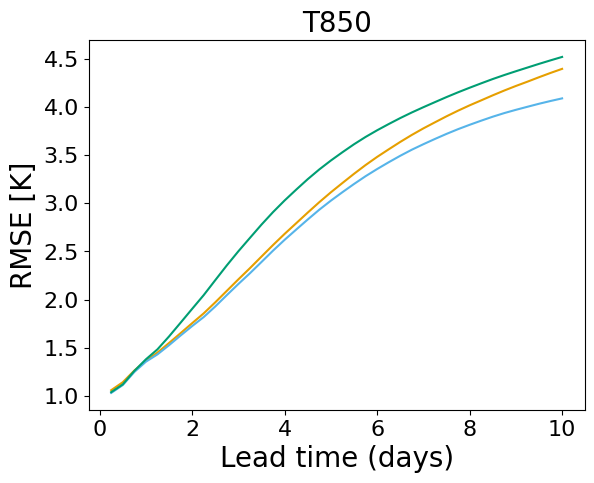

In [55]:
#plot results
plt.figure()
var = 'temperature'
metric = 'rmse'
title = 'T850'
level = 850
units = "[K]"

results_mse[var].sel(metric=metric, level=level, region='global').plot(label='MSE', color=colors['MSE'])
results_mae[var].sel(metric=metric, level=level, region='global').plot(label='MAE', color=colors['MAE'])
results_lch[var].sel(metric=metric, level=level, region='global').plot(label='Log-cosh', color=colors['Log-cosh'])


# Add legend, title and labels
if title == 'Z500':
    plt.legend(fontsize=20)
plt.title(title,fontsize=20)
plt.ylabel("RMSE " + units, fontsize=20 )
plt.xlabel("Lead time (days)", fontsize=20)
#plt.axhline(y=0, color='grey', linestyle='--')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#save plot to file
plt.savefig('../plots/RMSE_' + title + '.png', dpi=300, bbox_inches='tight')
    
# Show the plot
plt.show()


# spatial results
spatial results show the results by lon x lat on a world map

## Prediction
show one 10 day forecast for 2020-01-01

In [ ]:
# show predictions for 2020-01-01:
relative_path = "predictions/pred_64x32_2020_rae_eval.zarr"
pred_path = os.path.join(os.path.dirname(os.getcwd()), relative_path)
pred_data = xr.open_zarr(pred_path)
pred_data = pred_data.isel(time=0).compute()

In [ ]:
plt.figure()
g = pred_data['total_precipitation_6hr'].isel(prediction_timedelta=[12,20,40]).plot(x='longitude',
                                                                           y='latitude',
                                                                           col="prediction_timedelta",
                                                                           col_wrap=3,
                                                                           robust=True,
                                                                           subplot_kws={'projection': ccrs.PlateCarree()},
                                                                           aspect=1.5)
title = 'RAE_T2M'
# Manually set titles for each subplot
subtitles = ['3 days', '5 days', '10 days']
for ax, subtitle in zip(g.axs.flat, subtitles):
    ax.set_title(subtitle)
    ax.coastlines()

plt.suptitle(title, fontsize=16, x=0.4, y=1)
#plt.savefig('../plots/Predictions/' + title + '.png', dpi=300, bbox_inches='tight')
plt.show()

## bias map
show the bias maps for 2020

In [62]:
mse = xr.open_dataset('../evaluation/mse_spatial.nc')
mae = xr.open_dataset('../evaluation/mae_spatial.nc')
lch = xr.open_dataset('../evaluation/logcosh_spatial.nc')

In [63]:
# concatenate the spatial results into one dataset to help with plotting.
mse = mse.expand_dims('loss').assign_coords(loss=['MSE'])
mae = mae.expand_dims('loss').assign_coords(loss=['MAE'])
lch = lch.expand_dims('loss').assign_coords(loss=['Log-cosh'])

# Concatenate along the new 'loss' dimension
spatial_results = xr.concat([mse, mae, lch], dim='loss')
spatial_results

<xarray.Dataset>
Dimensions:                  (longitude: 64, lead_time: 41, latitude: 32,
                              level: 3, metric: 1, loss: 3, batch: 1)
Coordinates:
  * longitude                (longitude) float64 0.0 5.625 11.25 ... 348.8 354.4
  * lead_time                (lead_time) timedelta64[ns] 0 days 00:00:00 ... ...
  * latitude                 (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                    (level) int32 500 700 850
  * metric                   (metric) object 'bias'
  * loss                     (loss) <U8 'MSE' 'MAE' 'Log-cosh'
Dimensions without coordinates: batch
Data variables:
    2m_temperature           (loss, metric, batch, longitude, latitude, lead_time) float32 ...
    10m_u_component_of_wind  (loss, metric, batch, longitude, latitude, lead_time) float32 ...
    10m_v_component_of_wind  (loss, metric, batch, longitude, latitude, lead_time) float32 ...
    total_precipitation_6hr  (loss, metric, batch, longitude, latitude, lead_time) float32 ...
    geopotential             (loss, metric, batch, level, longitude, latitude, lead_time) float32 ...
    temperature              (loss, metric, batch, level, longitude, latitude, lead_time) float32 ...
    specific_humidity        (loss, metric, batch, level, longitude, latitude, lead_time) float32 ...

AttributeError: 'list' object has no attribute 'set_visible'

<Figure size 640x480 with 0 Axes>

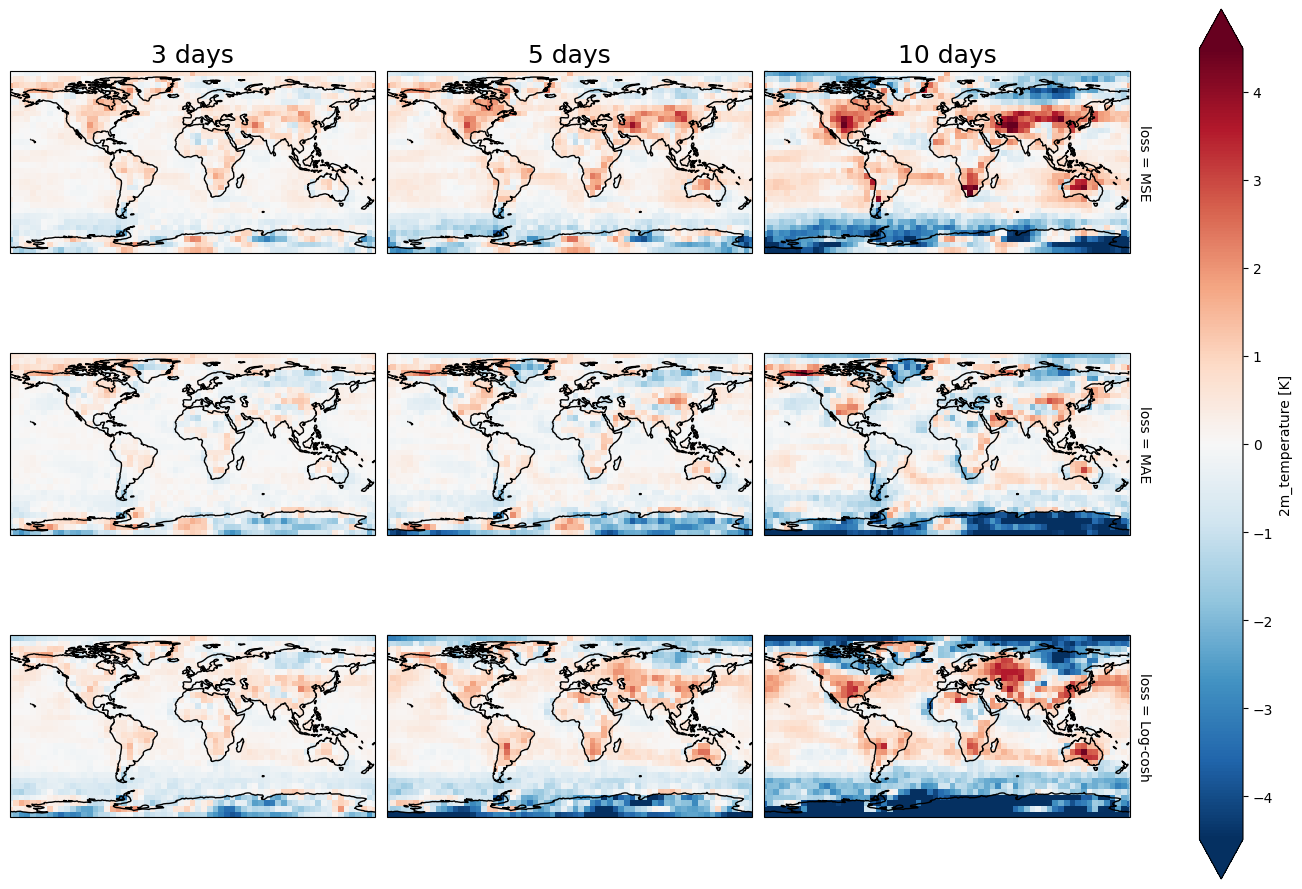

In [117]:
plt.figure()
var = '2m_temperature'
title = 'T2M'
units = " [K]"

lead_times = [np.timedelta64(3, 'D'),np.timedelta64(5, 'D'),np.timedelta64(10, 'D')]


g = spatial_results[var].sel(metric='bias', lead_time=lead_times).plot(x='longitude',y='latitude',
                                                                       col="lead_time",
                                                                       row="loss",
                                                                       robust=True, 
                                                                       cbar_kwargs={"label": var + units},
                                                                       subplot_kws={'projection': ccrs.PlateCarree()},
                                                                       aspect=1.5,
                                                                       )
    
# Manually set titles for each subplot
time_titles = ['3 days', '5 days', '10 days']
loss_titles = ['MSE', 'MAE', 'Log-cosh'] 

for ax, subtitle in zip(g.axs[0, :], time_titles):  
    ax.set_title(subtitle, fontsize=18)
    
for ax in g.axs.flat:
    ax.coastlines()

ax.yaxis.label.set_visible(False)

# for i, loss_title in enumerate(loss_titles):
#     ax = g.axs[i, 0]
#     ax.set_title(loss_title, fontsize=18)
#     #ax.text(-0.1, 0.5, loss_title, va='center', ha='right', rotation='vertical', rotation_mode='anchor', fontsize=18, transform=ax.transAxes)
#     #ax.yaxis.label.set_visible(False)

# Adjust the colorbar
g.row_labels.set_visible(False)

# Adjust the layout to reduce the distance between rows
plt.subplots_adjust(hspace=-0.2, wspace=0.03)

plt.suptitle(title, fontsize=25, x=0.5, y=1.05)
#plt.savefig('../plots/Bias_maps/' + title + '.png', dpi=300, bbox_inches='tight')


end of notebook.